# Online Learning Engagement Analytics

## Project Overview

This notebook explores student engagement in an online learning environment. The analysis will follow the complete data analysis workflow:

1. **Data Wrangling:** Clean the dataset by handling missing values, duplicates, outliers, and inconsistent formats.
2. **Exploratory Data Analysis (EDA):** Perform univariate and multivariate analyses with visualizations.
3. **Feature Engineering & Selection:** Create meaningful features and apply selection techniques.
4. **Probability & Hypothesis Testing:** Fit distributions, calculate probabilities, and conduct statistical tests.
5. **Dimensionality Reduction (PCA):** Reduce feature dimensions to visualize learner clusters.
6. **Insights & Recommendations:** Interpret findings and provide actionable insights.

The dataset contains 9,180 records with information on students' activity, course engagement, and completion status.


Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Feature Selection
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import Lasso, LinearRegression

# Dimensionality Reduction (PCA)
from sklearn.decomposition import PCA

# Statistical Analysis
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, mannwhitneyu, f_oneway, shapiro

# Machine Learning Models (optional for advanced analysis)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Utility
import warnings
warnings.filterwarnings("ignore")







Load Dataset

In [ ]:
df = pd.read_csv(r'/content/online_course_engagement_v5.csv')
df

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.189661,17.501015,2.956686,50.504203,20.372473,1,0
1,4326,Arts,29.129697,0.949412,5.049293,63.267924,64.941286,1,0
2,5849,Arts,86.417043,14.014453,1.832252,79.479229,61.244720,1,1
3,4992,Science,34.668974,16.927413,10.152430,59.276322,94.439492,0,1
4,3866,Programming,92.741137,16.547156,-0.170161,97.732338,19.161182,0,0
...,...,...,...,...,...,...,...,...,...
9175,378,Business,92.822698,4.072205,0.022576,100.007879,72.693295,0,0
9176,4645,Arts,24.272584,15.214393,8.234974,91.617470,28.892029,0,1
9177,7506,Health,38.755544,12.383174,5.307548,52.097772,69.522446,1,1
9178,6081,Programming,27.592151,9.083356,9.001102,88.028410,45.228263,1,1


## Step 1: Data Wrangling

In this step, we will:

- Check for missing values and handle them.
- Remove duplicates if any.
- Detect and handle outliers.
- Fix inconsistent formats in categorical columns.


Basic Info Before Cleaning

In [ ]:
# Dataset Overview
df.info()

# Statistical Summary
df.describe()

# Check Categorical Columns
df.select_dtypes(include='object').head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9180 entries, 0 to 9179
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9180 non-null   int64  
 1   CourseCategory         9180 non-null   object 
 2   TimeSpentOnCourse      8855 non-null   float64
 3   NumberOfVideosWatched  8852 non-null   float64
 4   NumberOfQuizzesTaken   8866 non-null   float64
 5   QuizScores             8845 non-null   float64
 6   CompletionRate         8905 non-null   float64
 7   DeviceType             9180 non-null   int64  
 8   CourseCompletion       9180 non-null   int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 645.6+ KB


,CourseCategory
0,Health
1,Arts
2,Arts
3,Science
4,Programming


### Checking for Missing Values

We will examine which columns have missing values and their counts.
For numerical columns, we will fill missing values with median (robust to outliers).
For categorical columns, we can fill with mode or leave as is if complete.


In [ ]:
# Check missing values
missing_values = df.isnull().sum()
missing_values


,0
UserID,0
CourseCategory,0
TimeSpentOnCourse,325
NumberOfVideosWatched,328
NumberOfQuizzesTaken,314
QuizScores,335
CompletionRate,275
DeviceType,0
CourseCompletion,0


### Handling Missing Values

We will fill missing numerical values with the median of each column.


In [ ]:
# Fill missing numerical values with median
numeric_cols = ["TimeSpentOnCourse", "NumberOfVideosWatched", "NumberOfQuizzesTaken", "QuizScores", "CompletionRate"]
for col in numeric_cols:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Verify missing values are handled
df.isnull().sum()


,0
UserID,0
CourseCategory,0
TimeSpentOnCourse,0
NumberOfVideosWatched,0
NumberOfQuizzesTaken,0
QuizScores,0
CompletionRate,0
DeviceType,0
CourseCompletion,0


###  Checking for Duplicates

We will check if there are duplicate rows and remove them if present.


In [ ]:
# Check duplicates
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates if any
df.drop_duplicates(inplace=True)
print(f"New shape of the DataFrame after removing duplicates: {df.shape}")

Number of duplicate rows: 180
New shape of the DataFrame after removing duplicates: (9000, 9)


Detecting Outliers (IQR Method)

In [ ]:
# Detect outliers using IQR
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Boolean DataFrame indicating outliers
outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))
outliers_count = outliers.sum()
outliers_count


,0
TimeSpentOnCourse,45
NumberOfVideosWatched,26
NumberOfQuizzesTaken,34
QuizScores,46
CompletionRate,30


###  Handling Outliers

For simplicity, we will cap outliers to the lower and upper bounds (1.5 * IQR) to reduce their effect on analysis.


In [ ]:
# Cap outliers
for col in numeric_cols:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Verify changes
df.describe()


,UserID,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4498.894556,50.064502,10.062918,5.102936,74.648808,50.250353,0.500667,0.396444
std,2596.849433,29.548806,6.154137,3.235649,14.893586,29.979075,0.500027,0.489186
min,1.000000,-47.451041,-10.412292,-6.395437,26.220814,-48.128220,0.000000,0.000000
25%,2251.750000,25.780882,4.894254,2.198211,62.494187,25.864184,0.000000,0.000000
50%,4483.500000,49.677878,10.143926,5.070705,74.723985,50.241008,1.000000,0.000000
75%,6751.250000,74.602164,15.098618,7.927310,86.676436,75.192454,1.000000,1.000000
max,9000.000000,147.834087,30.405164,16.520958,122.949810,149.184857,1.000000,1.000000


### Fixing Categorical Formats

- `DeviceType` is currently numeric; we will map it to meaningful strings.
- `CourseCategory` is already string, but we will check for inconsistent labels.


In [ ]:
# Map DeviceType
device_mapping = {0: 'Mobile', 1: 'Desktop', 2: 'Tablet'}  # adjust if needed
df['DeviceType'] = df['DeviceType'].map(device_mapping)

# Check unique values in CourseCategory
df['CourseCategory'].unique()


array(['Health', 'Arts', 'Science', 'Programming', 'Business'],
      dtype=object)

###  Final Clean Dataset Summary

After cleaning, we review the structure again to confirm everything is consistent and ready for EDA.


In [ ]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-null   float64
 4   NumberOfQuizzesTaken   9000 non-null   float64
 5   QuizScores             9000 non-null   float64
 6   CompletionRate         9000 non-null   float64
 7   DeviceType             9000 non-null   object 
 8   CourseCompletion       9000 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 703.1+ KB


,UserID,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,CourseCompletion
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,4498.894556,50.064502,10.062918,5.102936,74.648808,50.250353,0.396444
std,2596.849433,29.548806,6.154137,3.235649,14.893586,29.979075,0.489186
min,1.000000,-47.451041,-10.412292,-6.395437,26.220814,-48.128220,0.000000
25%,2251.750000,25.780882,4.894254,2.198211,62.494187,25.864184,0.000000
50%,4483.500000,49.677878,10.143926,5.070705,74.723985,50.241008,0.000000
75%,6751.250000,74.602164,15.098618,7.927310,86.676436,75.192454,1.000000
max,9000.000000,147.834087,30.405164,16.520958,122.949810,149.184857,1.000000


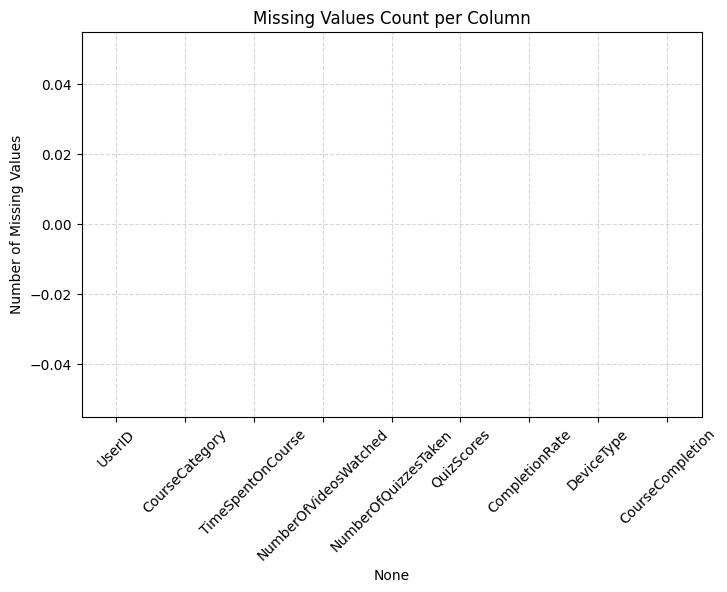

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Missing Values Visualization
plt.figure(figsize=(8,5))
missing_counts = df.isnull().sum()
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
plt.title("Missing Values Count per Column")
plt.ylabel("Number of Missing Values")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



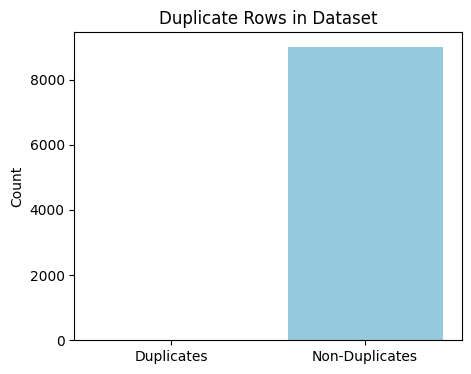

In [ ]:
# 2. Duplicate Rows Visualization
duplicate_count = df.duplicated().sum()
plt.figure(figsize=(5,4))
sns.barplot(x=['Duplicates', 'Non-Duplicates'], y=[duplicate_count, len(df)-duplicate_count], palette=['salmon','skyblue'])
plt.title("Duplicate Rows in Dataset")
plt.ylabel("Count")
plt.show()


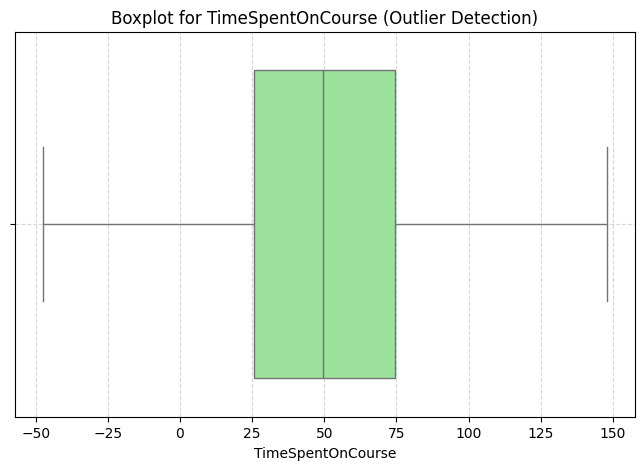

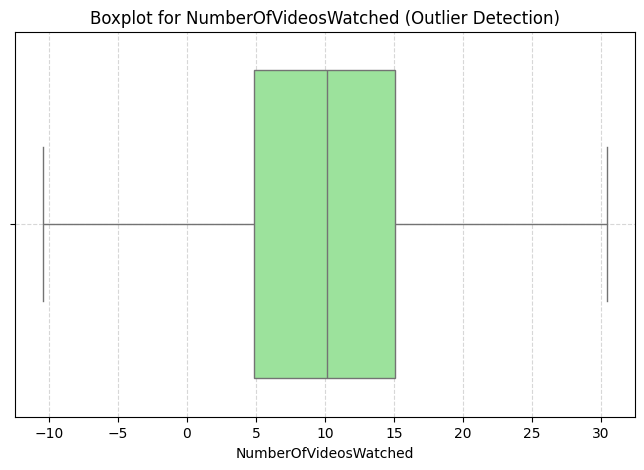

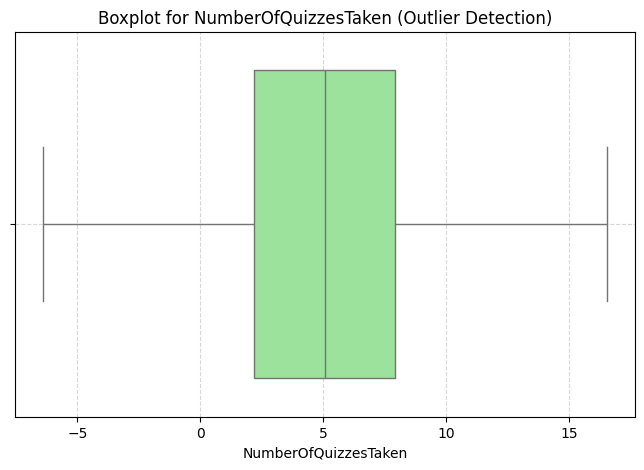

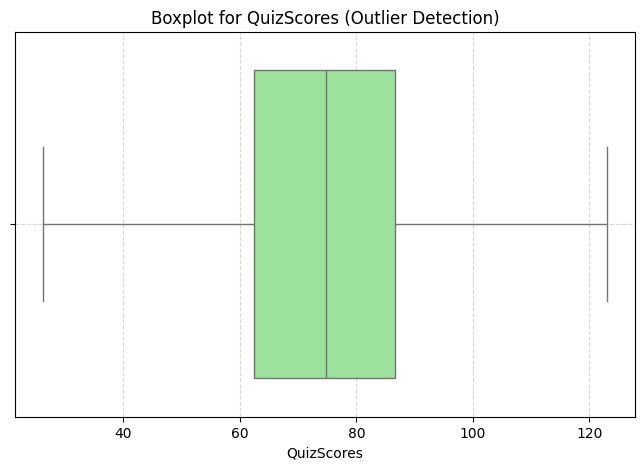

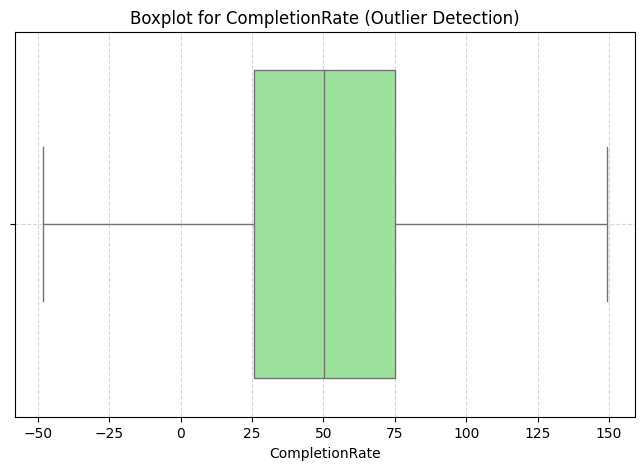

In [ ]:
# 3. Outlier Detection (IQR) - Boxplots for numeric columns
numeric_cols = ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate']

for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot for {col} (Outlier Detection)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

**Exploratory Data Analysis (EDA)**: Perform univariate and multivariate analyses with visualizations.

Univariate analysis for numerical columns

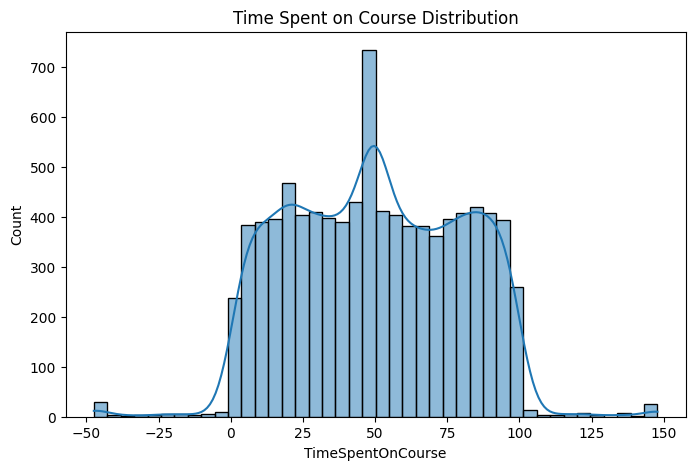

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['TimeSpentOnCourse'], kde=True)
plt.title("Time Spent on Course Distribution")
plt.show()

**Insights**


some values in negative

In [ ]:
df = df[df['TimeSpentOnCourse'] >= 0 & (df['TimeSpentOnCourse'] <= 100)]


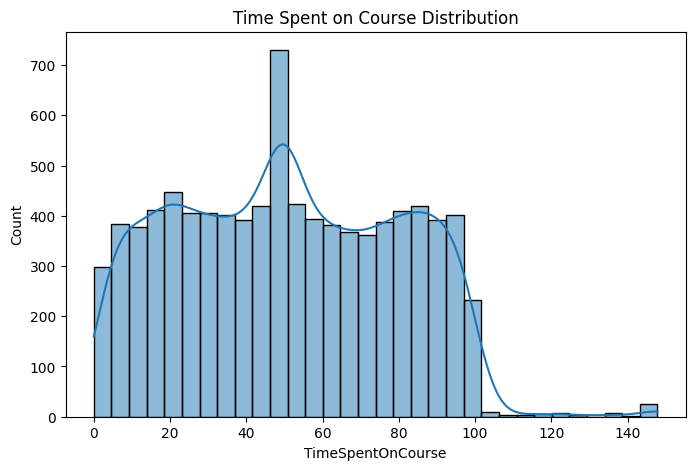

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['TimeSpentOnCourse'], kde=True)
plt.title("Time Spent on Course Distribution")
plt.show()

**NumberOfVideosWatched Distribution**

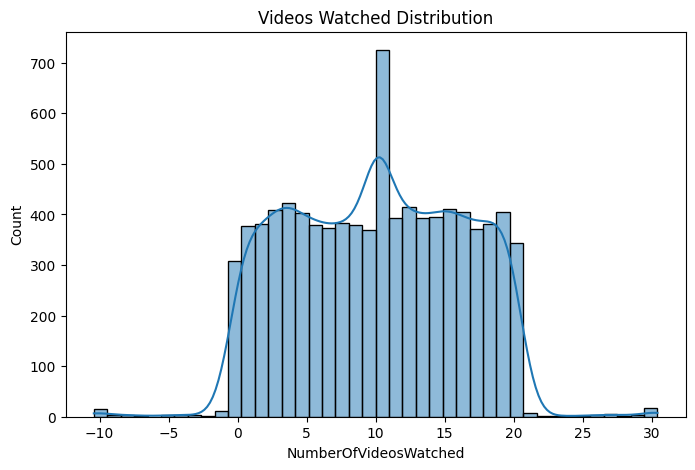

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['NumberOfVideosWatched'], kde=True)
plt.title("Videos Watched Distribution")
plt.show()

**INSIGHTS:**
- Most students watch between 5 and 15 videos, indicating a moderate engagement level.
- The presence of negative values is logically inconsistent for this variable and indicates data quality issues. These records will require cleaning or removal.


**Removal of negative values**

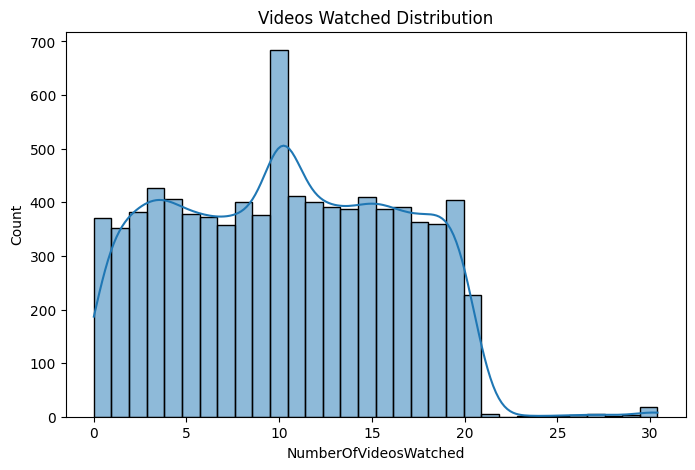

In [ ]:
df = df[df['NumberOfVideosWatched'] >= 0]
plt.figure(figsize=(8,5))
sns.histplot(df['NumberOfVideosWatched'], kde=True)
plt.title("Videos Watched Distribution")
plt.show()


**Quiz Scores Distribution**

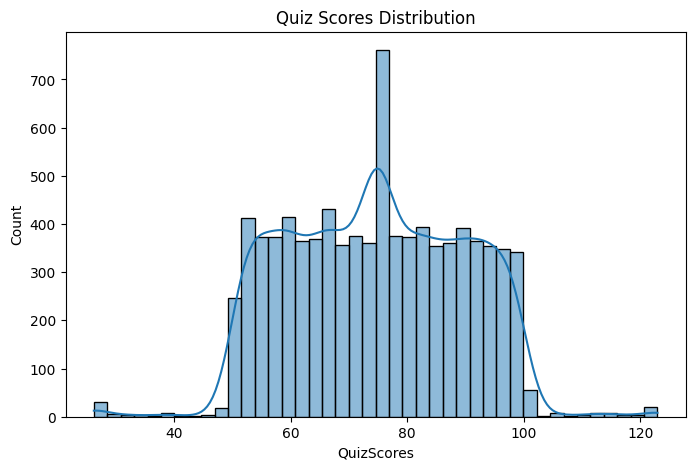

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['QuizScores'], kde=True)
plt.title("Quiz Scores Distribution")
plt.show()

**INSIGHT:**
- The average score is approximately 75%, which indicates a generally good performance level among learners.
- Scores exceeding 100% are not logically valid and represent clear outliers. These values require further cleaning or removal.


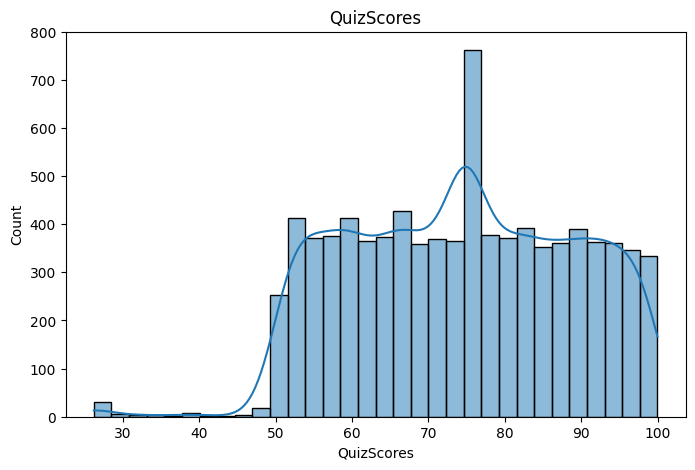

In [ ]:
df = df[(df['QuizScores'] >= 0) & (df['QuizScores'] <= 100)]
plt.figure(figsize=(8,5))
sns.histplot(df['QuizScores'], kde=True)
plt.title("QuizScores")
plt.show()


**Completion Rate Distribution**

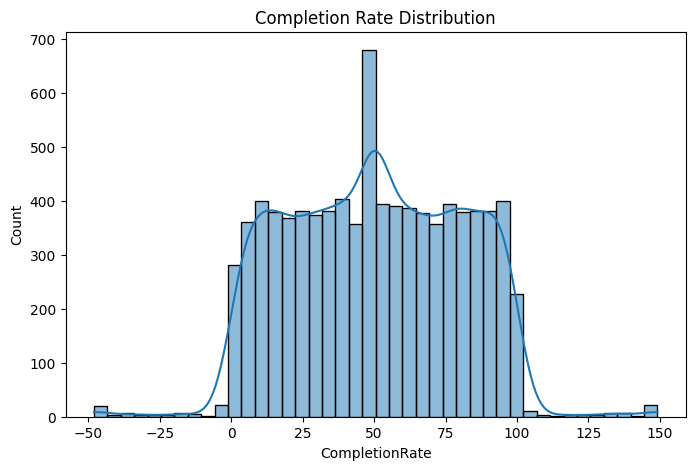

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['CompletionRate'], kde=True)
plt.title("Completion Rate Distribution")
plt.show()

**INSIGHT:**
- The valid CompletionRate values are concentrated around 50%, indicating that most learners complete roughly half of the course.
- The presence of values below 0% or above 100% is logically invalid and indicates data quality issues. These records should be cleaned or removed before further analysis.


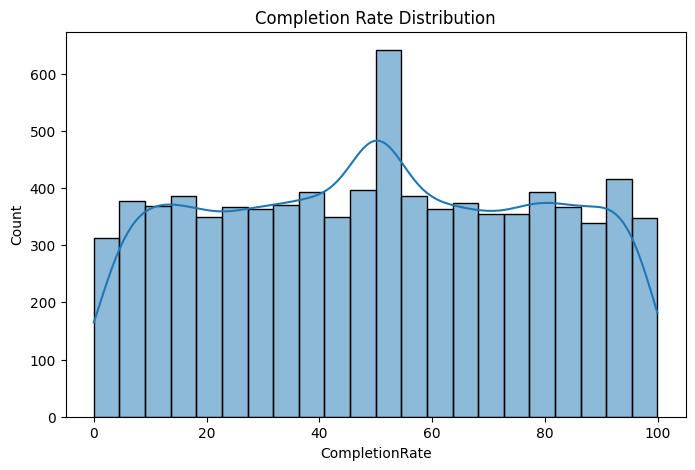

In [ ]:
# Remove values less than 0 or greater than 100
df = df[(df['CompletionRate'] >= 0) & (df['CompletionRate'] <= 100)]
plt.figure(figsize=(8,5))
sns.histplot(df['CompletionRate'], kde=True)
plt.title("Completion Rate Distribution")
plt.show()


**EDA for Categorical Columns**


**DeviceType Count Plot**
- This distribution shows which device type is most commonly used by learners.

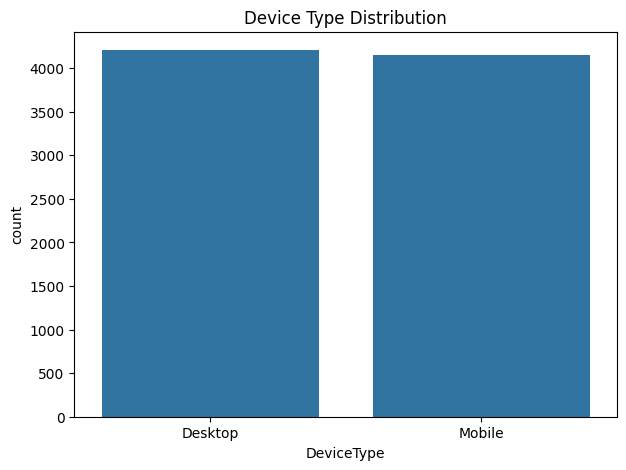

In [ ]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='DeviceType')
plt.title("Device Type Distribution")
plt.show()


**INSIGHTS**
- Device choice may influence the learning experience and potentially affect course completion rates.


**Multivariate Analysis**

**TimeSpent vs CourseCompletion**

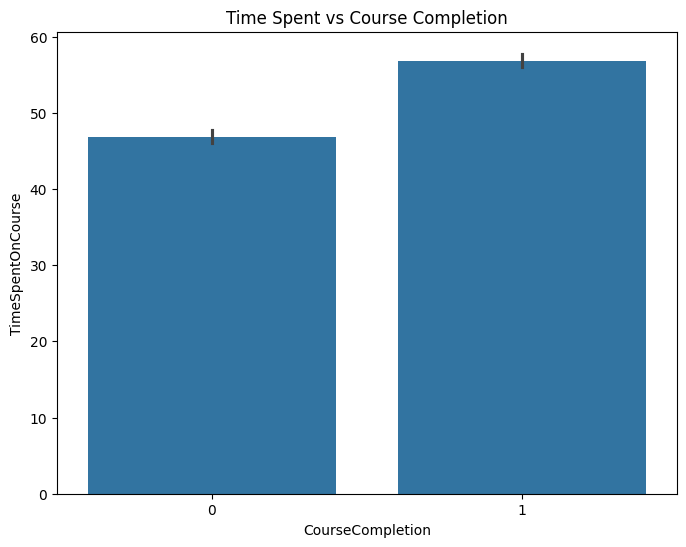

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(data=df, x='CourseCompletion', y='TimeSpentOnCourse')
plt.title("Time Spent vs Course Completion")
plt.show()

 **Insights**

 Learners who spend more time on the platform tend to have higher completion rates (Class = 1).

QuizScores vs CourseCompletion

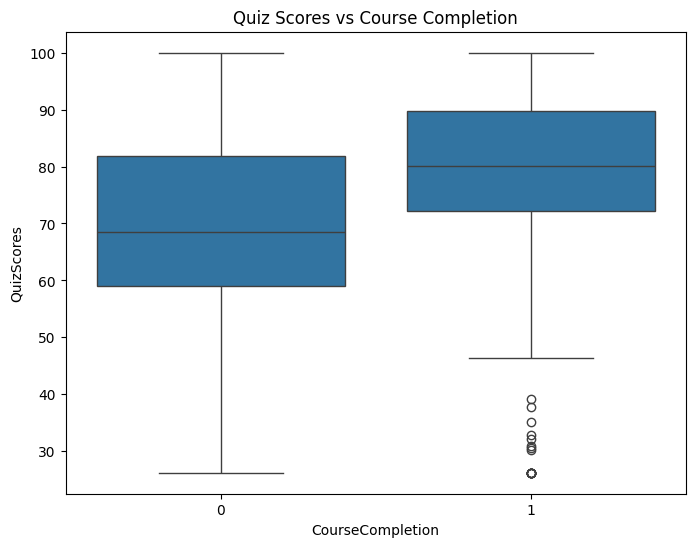

In [ ]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='CourseCompletion', y='QuizScores')
plt.title("Quiz Scores vs Course Completion")
plt.show()

**INSIGHTS**
- Quiz scores are noticeably higher among learners who completed the course.
- This suggests a strong relationship between academic performance and course completion.


**NumberOfVideosWatched vs CourseCompletion**

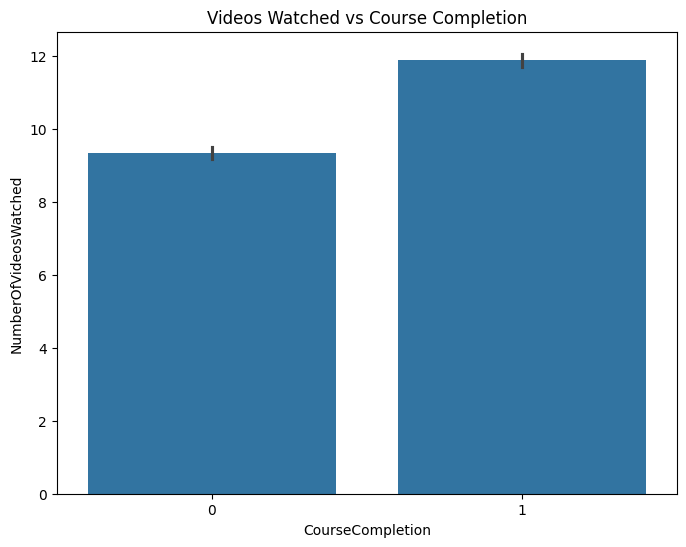

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(data=df, x='CourseCompletion', y='NumberOfVideosWatched')
plt.title("Videos Watched vs Course Completion")
plt.show()

**INSIGHTS**
- Learners who complete the course tend to watch significantly more videos.


DeviceType vs CourseCompletion
Count plot for Categorical columns

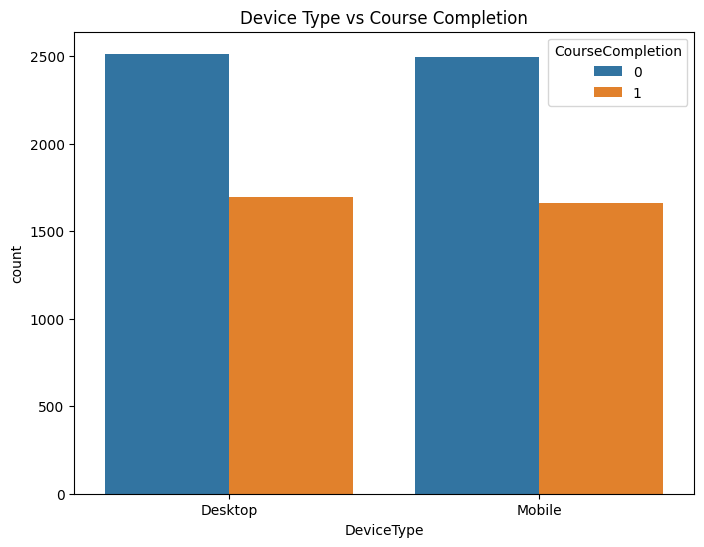

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='DeviceType', hue='CourseCompletion')
plt.title("Device Type vs Course Completion")
plt.show()


**Users on Mobile and Desktop have almost the same likelihood of completing or not completing the course.**

**Correlation Heatmap**

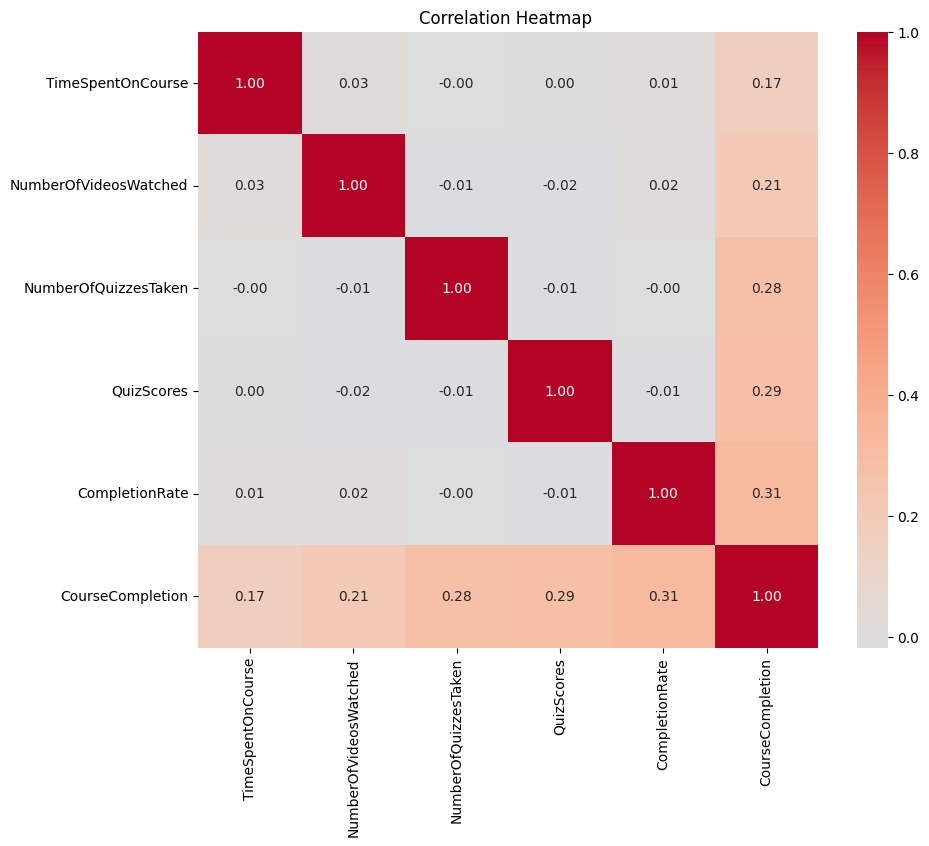

In [ ]:
numeric_cols = ['TimeSpentOnCourse', 'NumberOfVideosWatched',
                'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'CourseCompletion']

corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap ")
plt.show()

Step 3 : Feature Engineering & Selection

We created new engagement-related features to better capture student activity patterns.


Feature Engineering :
 Engagement Intensity,
 Average Quiz Score per Quiz ,
 Video Completion Ratio,
 Binary Feature: High Engagement

In [ ]:
df['EngagementIntensity'] = (
    df['TimeSpentOnCourse'] +
    df['NumberOfVideosWatched'] * 2 +
    df['NumberOfQuizzesTaken'] * 3
)
df['EngagementIntensity']

,EngagementIntensity
0,73.061751
1,46.176399
2,119.942706
3,98.981088
4,125.324967
...,...
8994,37.838296
8995,78.793444
8997,54.407245
8998,125.859255


In [ ]:
df['AvgQuizScore'] = df['QuizScores'] / (df['NumberOfQuizzesTaken'] + 1)
df['AvgQuizScore']

,AvgQuizScore
0,12.764268
1,10.458731
2,28.062203
3,5.315104
4,117.772586
...,...
8994,14.077127
8995,10.999455
8997,16.462079
8998,7.140283


In [ ]:
df['VideoTimeRatio'] = df['NumberOfVideosWatched'] / (df['TimeSpentOnCourse'] + 1)
df['VideoTimeRatio']

,VideoTimeRatio
0,0.579702
1,0.031511
2,0.160317
3,0.474570
4,0.176520
...,...
8994,0.125298
8995,0.375473
8997,0.061057
8998,0.183901


In [ ]:
df['HighEngagement'] = np.where(df['EngagementIntensity'] > df['EngagementIntensity'].median(), 1, 0)
df['HighEngagement']

,HighEngagement
0,0
1,0
2,1
3,1
4,1
...,...
8994,0
8995,0
8997,0
8998,1


Encoding categorical variables :
DeviceType Encoding

In [ ]:
le = LabelEncoder()
df['DeviceType_encoded'] = le.fit_transform(df['DeviceType'])
df['DeviceType_encoded']

,DeviceType_encoded
0,0
1,0
2,0
3,1
4,1
...,...
8994,1
8995,0
8997,0
8998,0


Feature Scaling ( for selecting and PCA )

In [ ]:
scaler = StandardScaler()

scaled_features = [
    'TimeSpentOnCourse',
    'NumberOfVideosWatched',
    'NumberOfQuizzesTaken',
    'QuizScores',
    'CompletionRate',
    'EngagementIntensity',
    'AvgQuizScore',
    'VideoTimeRatio'
]

df_scaled = pd.DataFrame(
    scaler.fit_transform(df[scaled_features]),
    columns=scaled_features
)
df_scaled

,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,EngagementIntensity,AvgQuizScore,VideoTimeRatio
0,-0.757988,1.204984,-0.659391,-1.637496,-1.062639,-0.422095,-0.325752,0.212961
1,-0.760083,-1.592011,-0.009919,-0.755913,0.521352,-1.244174,-0.436039,-0.452888
2,1.241731,0.615803,-1.008376,0.363793,0.389975,1.011393,0.406037,-0.296436
3,-0.566522,1.108053,1.573917,-1.031611,1.569728,0.370445,-0.682089,0.085264
4,1.462716,1.043795,-1.629854,1.624525,-1.105688,1.175967,4.697404,-0.276756
...,...,...,...,...,...,...,...,...
8358,-1.150689,-1.351178,-0.010970,0.752635,1.538877,-1.499130,-0.262951,-0.338971
8359,-0.453734,0.715542,-0.367923,-1.406328,-0.557115,-0.246836,-0.410173,-0.035101
8360,-0.380678,-1.329546,-0.603048,-0.420523,0.738048,-0.992498,-0.148865,-0.416999
8361,0.664277,0.450637,1.515590,0.281628,0.806622,1.192304,-0.594780,-0.267790


Feature Selection :
Target Variable

In [ ]:
y = df['CourseCompletion']
X = df_scaled
print (X)


      TimeSpentOnCourse  NumberOfVideosWatched  NumberOfQuizzesTaken  \
0             -0.757988               1.204984             -0.659391   
1             -0.760083              -1.592011             -0.009919   
2              1.241731               0.615803             -1.008376   
3             -0.566522               1.108053              1.573917   
4              1.462716               1.043795             -1.629854   
...                 ...                    ...                   ...   
8358          -1.150689              -1.351178             -0.010970   
8359          -0.453734               0.715542             -0.367923   
8360          -0.380678              -1.329546             -0.603048   
8361           0.664277               0.450637              1.515590   
8362           1.476360              -0.559427             -0.065746   

      QuizScores  CompletionRate  EngagementIntensity  AvgQuizScore  \
0      -1.637496       -1.062639            -0.422095     -0.325

SelectKBest (ANOVA F-test)

In [ ]:
selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X, y)

selected_features = X.columns[selector.get_support()]
print("Top 5 Selected Features:", list(selected_features))


Top 5 Selected Features: ['NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'EngagementIntensity']


Recursive Feature Elimination (RFE)

In [ ]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)

rfe_features = X.columns[rfe.support_]
print("RFE Selected Features:", list(rfe_features))


RFE Selected Features: ['NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'EngagementIntensity']


LASSO Feature Selection

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)

lasso_features = X.columns[lasso.coef_ != 0]
print("LASSO Selected Features:", list(lasso_features))


LASSO Selected Features: ['NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'EngagementIntensity', 'AvgQuizScore', 'VideoTimeRatio']


Feature selection results indicate that engagement and performance-related features are the most influential factors affecting course completion.


In [ ]:
feature_selection_summary = pd.DataFrame({
    'SelectKBest': selected_features,
    'RFE': rfe_features,
    'LASSO': lasso_features[:len(rfe_features)]
})

feature_selection_summary


,SelectKBest,RFE,LASSO
0,NumberOfVideosWatched,NumberOfVideosWatched,NumberOfVideosWatched
1,NumberOfQuizzesTaken,NumberOfQuizzesTaken,NumberOfQuizzesTaken
2,QuizScores,QuizScores,QuizScores
3,CompletionRate,CompletionRate,CompletionRate
4,EngagementIntensity,EngagementIntensity,EngagementIntensity


The feature selection results show strong consistency across SelectKBest, RFE, and LASSO methods. This consistency confirms that engagement-related features and quiz performance are the most influential factors affecting course completion, while other variables have comparatively less impact.

After Feature Engineering:

The engineered features provide a more comprehensive representation of student engagement compared to raw activity metrics.

After Feature Selection:

Multiple feature selection techniques consistently identified engagement-based features as key predictors of course completion.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8363 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 8363 non-null   int64  
 1   CourseCategory         8363 non-null   object 
 2   TimeSpentOnCourse      8363 non-null   float64
 3   NumberOfVideosWatched  8363 non-null   float64
 4   NumberOfQuizzesTaken   8363 non-null   float64
 5   QuizScores             8363 non-null   float64
 6   CompletionRate         8363 non-null   float64
 7   DeviceType             8363 non-null   object 
 8   CourseCompletion       8363 non-null   int64  
 9   EngagementIntensity    8363 non-null   float64
 10  AvgQuizScore           8363 non-null   float64
 11  VideoTimeRatio         8363 non-null   float64
 12  HighEngagement         8363 non-null   int64  
 13  DeviceType_encoded     8363 non-null   int64  
dtypes: float64(8), int64(4), object(2)
memory usage: 980.0+ KB


In [ ]:
df.head()

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion,EngagementIntensity,AvgQuizScore,VideoTimeRatio,HighEngagement,DeviceType_encoded
0,5618,Health,29.189661,17.501015,2.956686,50.504203,20.372473,Desktop,0,73.061751,12.764268,0.579702,0,0
1,4326,Arts,29.129697,0.949412,5.049293,63.267924,64.941286,Desktop,0,46.176399,10.458731,0.031511,0,0
2,5849,Arts,86.417043,14.014453,1.832252,79.479229,61.244720,Desktop,1,119.942706,28.062203,0.160317,1,0
3,4992,Science,34.668974,16.927413,10.152430,59.276322,94.439492,Mobile,1,98.981088,5.315104,0.474570,1,1
4,3866,Programming,92.741137,16.547156,-0.170161,97.732338,19.161182,Mobile,0,125.324967,117.772586,0.176520,1,1


Normality test

In [ ]:
for col in numeric_cols:
    stat, p = stats.shapiro(df[col])
    result = "Normal" if p > 0.05 else "Not Normal"
    print(f"{col}: p-value = {p:.4f} -> {result}")


TimeSpentOnCourse: p-value = 0.0000 -> Not Normal
NumberOfVideosWatched: p-value = 0.0000 -> Not Normal
NumberOfQuizzesTaken: p-value = 0.0000 -> Not Normal
QuizScores: p-value = 0.0000 -> Not Normal
CompletionRate: p-value = 0.0000 -> Not Normal
CourseCompletion: p-value = 0.0000 -> Not Normal


Observation: Shapiro-Wilk normality tests showed all numeric variables are not normally distributed, so we will use non-parametric tests.

Probability Analysis

A-Probability of High Engagement

In [ ]:
from scipy.stats import levene

stat, p = levene(desktop_scores, mobile_scores)
print(f"Levene Test: stat={stat:.3f}, p={p:.4f}")


Levene Test: stat=0.344, p=0.5578


Levene’s test indicated no significant difference in variances between the two groups (p = 0.5578), satisfying the equal variance assumption. Normality was assessed separately using the Shapiro-Wilk test.

In [ ]:
# Proportion of students with HighEngagement = 1
high_engaged = df['HighEngagement'].sum()
total_students = len(df)
p_high_engagement = high_engaged / total_students

print(f"P(High Engagement) = {p_high_engagement:.3f}")
high_engaged = df['HighEngagement'].sum()
total_students = len(df)
p_high_engagement = high_engaged / total_students
#we will use in conditional prob

print(f"P(High Engagement) = {p_high_engagement:.3f}")


P(High Engagement) = 0.500
P(High Engagement) = 0.500


B Conditional Probability: High Engagement by Device Type

In [ ]:
# Conditional probability P(HighEngagement | DeviceType)
prob_desktop = df[df['DeviceType']=='Desktop']['HighEngagement'].mean()
prob_mobile  = df[df['DeviceType']=='Mobile']['HighEngagement'].mean()

print(f"P(HighEngagement | Desktop) = {prob_desktop:.3f}")
print(f"P(HighEngagement | Mobile) = {prob_mobile:.3f}")


P(HighEngagement | Desktop) = 0.501
P(HighEngagement | Mobile) = 0.499


The probability of a student being highly engaged is almost the same regardless of the device type (Desktop or Mobile).

Device type does not appear to significantly affect engagement, which is consistent with the close probabilities.

Hypothesis testing

t test

In [ ]:
from scipy.stats import ttest_ind

# Separate QuizScores by DeviceType
desktop_scores = df[df['DeviceType']=='Desktop']['QuizScores']
mobile_scores  = df[df['DeviceType']=='Mobile']['QuizScores']

# Independent two-sample t-test
t_stat, p_val = ttest_ind(desktop_scores, mobile_scores, equal_var=False)  # Welch's t-test

print(f"Independent t-test: t={t_stat:.3f}, p={p_val:.4f}")

if p_val < 0.05:
    print("Result: Significant difference in QuizScores between devices.")
else:
    print("Result: No significant difference between devices.")


Independent t-test: t=0.106, p=0.9158
Result: No significant difference between devices.


Test: Mann-Whitney U Test (non-parametric alternative to t-test)

Hypothesis:

H0: No difference in QuizScores between Desktop and Mobile users.

H1: QuizScores differ between Desktop and Mobile users

In [ ]:
from scipy.stats import mannwhitneyu

desktop_scores = df[df['DeviceType']=='Desktop']['QuizScores']
mobile_scores  = df[df['DeviceType']=='Mobile']['QuizScores']

u_stat, p_val = mannwhitneyu(desktop_scores, mobile_scores, alternative='two-sided')
print(f"Mann-Whitney U Test: U={u_stat:.3f}, p={p_val:.4f}")

if p_val < 0.05:
    print("Result: Significant difference in QuizScores between devices.")
else:
    print("Result: No significant difference between devices.")


Mann-Whitney U Test: U=8779565.500, p=0.7343
Result: No significant difference between devices.


CourseCategory vs CompletionRate

Test: Kruskal-Wallis Test (non-parametric alternative to ANOVA)
Because anova is for parametric
Hypothesis:

H0: CompletionRate is the same across all course categories.

H1: CompletionRate differs among categories.

In [ ]:
from scipy.stats import kruskal

categories = df['CourseCategory'].unique()
grouped_data = [df[df['CourseCategory']==cat]['CompletionRate'] for cat in categories]

h_stat, p_val = kruskal(*grouped_data)
print(f"Kruskal-Wallis Test: H={h_stat:.3f}, p={p_val:.4f}")

if p_val < 0.05:
    print("Result: Significant difference in CompletionRate among categories.")
else:
    print("Result: No significant difference among categories.")


Kruskal-Wallis Test: H=2.686, p=0.6116
Result: No significant difference among categories.


Anova

In [ ]:
from scipy.stats import f_oneway

# Prepare data per CourseCategory
grouped_data = [df[df['CourseCategory']==cat]['CompletionRate'] for cat in categories]

# One-way ANOVA
f_stat, p_val = f_oneway(*grouped_data)
print(f"One-way ANOVA: F={f_stat:.3f}, p={p_val:.4f}")

if p_val < 0.05:
    print("Result: Significant difference in CompletionRate among categories.")
else:
    print("Result: No significant difference among categories.")


One-way ANOVA: F=0.712, p=0.5834
Result: No significant difference among categories.


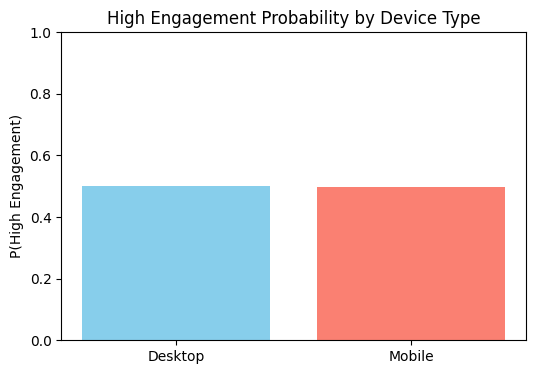

In [ ]:
#visualization

probabilities = [0.501, 0.499]
devices = ['Desktop', 'Mobile']

plt.figure(figsize=(6,4))
plt.bar(devices, probabilities, color=['skyblue','salmon'])
plt.ylabel('P(High Engagement)')
plt.title('High Engagement Probability by Device Type')
plt.ylim(0,1)
plt.show()


All numeric distributions were tested for normality.

Non-parametric tests (Mann-Whitney, Kruskal-Wallis) were used due to non-normality.and we tried also using Anova and ttest

Conditional probabilities are calculated to show engagement patterns.

Visualizations confirm patterns and differences, supporting the statistical tests.

###  Data Preprocessing for PCA
Before applying Principal Component Analysis (PCA), it is essential to preprocess the data. PCA is highly sensitive to the scale of the features and cannot handle missing values natively. Therefore, we perform two key steps:
1. **Imputation:** Handling missing values by replacing them with the mean of each column.
2. **Standardization:** Scaling the data so that all features have a mean of 0 and a standard deviation of 1. This ensures that features with larger ranges do not dominate the analysis.

In [ ]:


# Select numerical columns for PCA
# Based on your dataframe, these are the relevant numerical features
numeric_cols = [
    'TimeSpentOnCourse',
    'NumberOfVideosWatched',
    'NumberOfQuizzesTaken',
    'QuizScores',
    'CompletionRate',
    'EngagementIntensity',
    'AvgQuizScore',
    'VideoTimeRatio'
]

# Ensure we are using the cleaned dataframe 'df'
# Check if the columns exist in df, if not, use the ones available
available_cols = [col for col in numeric_cols if col in df.columns]
print(f"Columns used for PCA: {available_cols}")

# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[available_cols])

# Convert back to DataFrame for better handling (optional but good for checking)
df_scaled = pd.DataFrame(df_scaled, columns=available_cols)

Columns used for PCA: ['TimeSpentOnCourse', 'NumberOfVideosWatched', 'NumberOfQuizzesTaken', 'QuizScores', 'CompletionRate', 'EngagementIntensity', 'AvgQuizScore', 'VideoTimeRatio']


 ### Explained Variance Analysis & Scree Plot
We fit the PCA model to the standardized data to determine the contribution of each principal component. The **Scree Plot** below visualizes the cumulative explained variance, helping us decide the optimal number of components to retain. Our goal is to find the number of components that explain at least **95%** of the total variance in the dataset.

In [ ]:
# Initialize PCA
pca = PCA()
pca.fit(df_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine how many components are needed to explain 95% of the variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components to explain 95% variance: {n_components_95}")
print(f"Explained Variance Ratios:\n{pca.explained_variance_ratio_}")

Number of components to explain 95% variance: 6
Explained Variance Ratios:
[2.80143249e-01 2.07205638e-01 1.62904712e-01 1.26460375e-01
 1.23336381e-01 6.05264099e-02 3.94232352e-02 1.48954464e-17]


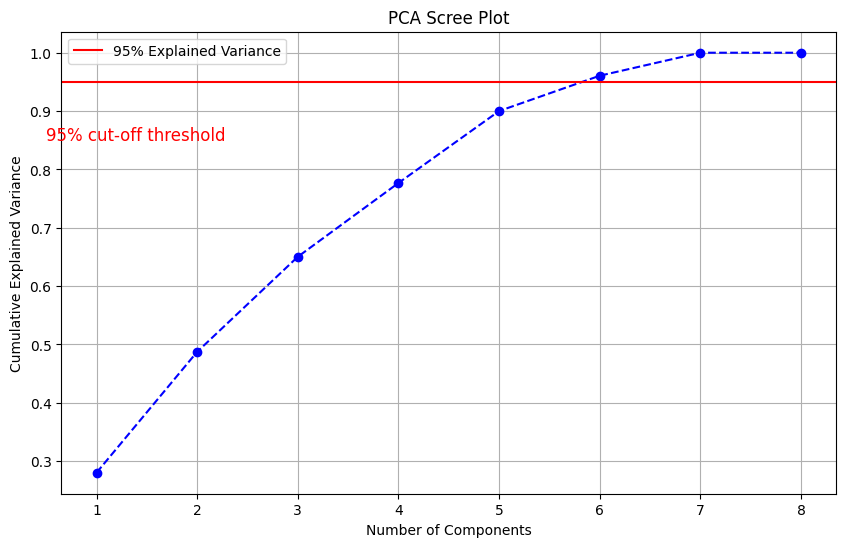

In [ ]:
plt.figure(figsize=(10, 6))

# Plot cumulative variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')

# Add a horizontal line at 95% variance
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(True)
plt.legend()
plt.show()

### 2D Visualization of Principal Components
To visualize the data structure in a lower-dimensional space, we project the dataset onto the first two principal components (PC1 and PC2). The scatter plot below is color-coded by **Course Completion** status. This helps us observe if the reduced features provide a clear separation between students who completed the course and those who did not.

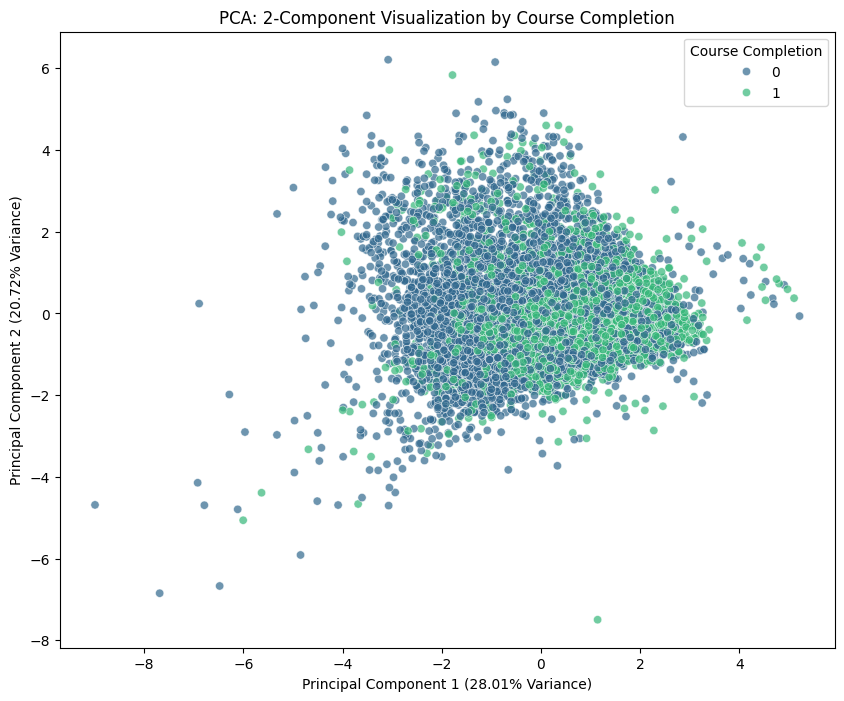

In [ ]:
# Apply PCA with 2 components for visualization
pca_2d = PCA(n_components=2)
principal_components = pca_2d.fit_transform(df_scaled)

# Create a DataFrame for the principal components
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Add the target variable 'CourseCompletion' back for color coding
# Reset index of df to ensure alignment if rows were dropped during cleaning
pca_df['CourseCompletion'] = df['CourseCompletion'].values

# Visualize the 2D Projection
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='CourseCompletion',
    data=pca_df,
    palette='viridis',
    alpha=0.7
)
plt.title('PCA: 2-Component Visualization by Course Completion')
plt.xlabel(f'Principal Component 1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel(f'Principal Component 2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.legend(title='Course Completion')
plt.show()

###  Interpreting Principal Components (Feature Loadings)
PCA transforms original features into new uncorrelated variables, but interpreting them can be challenging. To understand what each Principal Component represents, we analyze the **Feature Loadings**. The heatmap below shows the correlation between the original features and the first two principal components. A high positive or negative value indicates that the feature strongly influences that component.

Feature contribution to the first 2 Principal Components:


,PC1,PC2
TimeSpentOnCourse,0.573171,0.327631
NumberOfVideosWatched,0.133601,-0.030775
NumberOfQuizzesTaken,0.281269,-0.602403
QuizScores,-0.041240,0.190402
CompletionRate,0.023279,-0.001420
EngagementIntensity,0.633034,0.097510
AvgQuizScore,-0.256554,0.631969
VideoTimeRatio,-0.325145,-0.289263


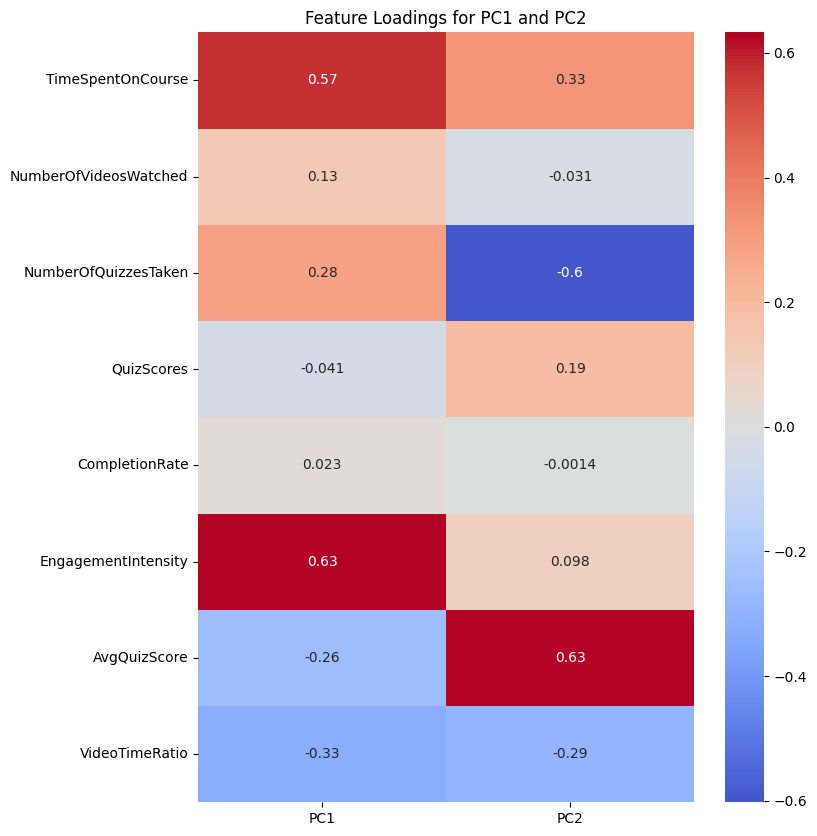

In [ ]:
# Create a dataframe of the components (loadings)
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=available_cols
)

print("Feature contribution to the first 2 Principal Components:")
display(loadings)

# Visualizing the loadings with a heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Loadings for PC1 and PC2')
plt.show()